In [1]:
import os, glob, numpy as np, matplotlib.pyplot as plt, pandas as pd 
from tensorboard.backend.event_processing import event_accumulator 
from collections import defaultdict 

In [2]:
LOG_DIRS = ["./env-search-2"] 

SAVE_NUMPY = False 

STORE_EVERYTHING_SIZE_GUIDANCE = {
    'compressedHistograms': 0, 
    'images': 0, 
    'audio': 0, 
    'scalars': 0, 
    'histograms': 0, 
} 

INITIAL_CUT = 0  
CUT = 190_000  
SMOOTH = 2000   

In [3]:
def get_values(filename): 
    ea = event_accumulator.EventAccumulator(filename, size_guidance=STORE_EVERYTHING_SIZE_GUIDANCE)
    ea.Reload()
    res = {} 
    # print(ea.Tags()) 
    for s in ea.Tags()["scalars"]: 
        res[s] = pd.DataFrame(ea.Scalars(tag=s))['value'].to_numpy() 
    return res  

In [4]:
if SAVE_NUMPY: 
    logs = glob.glob(os.path.join(LOG_DIRS[-1], "*/**/event*"), recursive=True) 
    for log in logs: 
        print(log) 
        res = get_values(log)
        path = "/".join(log.split("/")[:-1]) 
        for key,value in res.items(): 
            if not os.path.isdir(path+"/rewards/"): os.mkdir(path+"/rewards/") 
            with open(path+"/rewards/"+key+".npy", "wb") as f: 
                np.save(f, value) 

In [5]:
def smooth(y, box_pts=100):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    # return np.array(pd.Series(y).rolling(box_pts).mean()) 
    return y_smooth

In [6]:
logs = [] 
[logs.extend(glob.glob(os.path.join(log_dir, "*/**/agent_0_reward.npy"), recursive=True)) for log_dir in LOG_DIRS] 
# print(logs) 

exps = set() 
[exps.add("--".join(l.split("/")[-3].split("--")[:-1])) for l in logs] 
print("Exps\n", exps) 

envs = set()
[envs.add(e.split("--")[1]) for e in exps]
print("\n\nEnvs\n", envs) 

Exps
 {'giam--simple_adversary_v2--n_2', 'noam--simple_spread_v2--n_2', 'giam--simple_tag_v2--n_2', 'noam--simple_tag_v2--n_2', 'giam--simple_spread_v2--n_2', 'noam--simple_adversary_v2--n_2', 'noam--simple_world_comm_v2--n_2', 'giam--simple_world_comm_v2--n_2'}


Envs
 {'simple_tag_v2', 'simple_world_comm_v2', 'simple_adversary_v2', 'simple_spread_v2'}


In [7]:
# envs = {'simple_world_comm_v2'} 

exp: giam--simple_tag_v2--n_2
exp: noam--simple_tag_v2--n_2


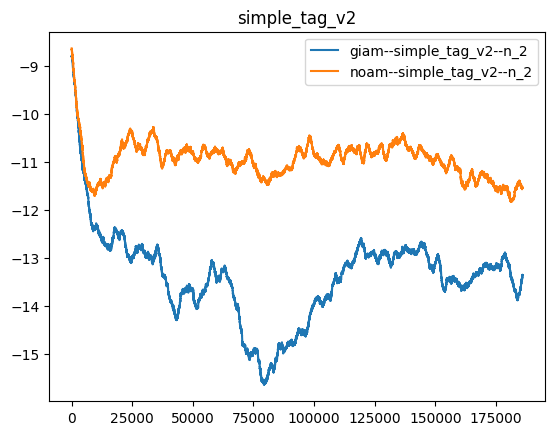

exp: noam--simple_world_comm_v2--n_2
exp: giam--simple_world_comm_v2--n_2


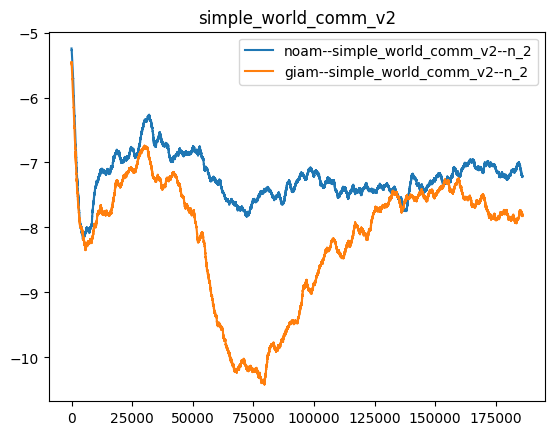

exp: giam--simple_adversary_v2--n_2
exp: noam--simple_adversary_v2--n_2


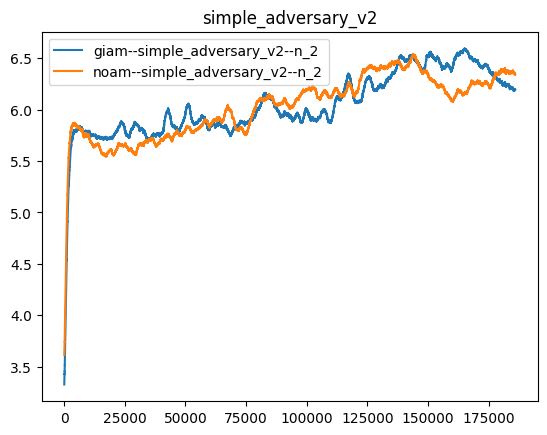

exp: noam--simple_spread_v2--n_2
exp: giam--simple_spread_v2--n_2


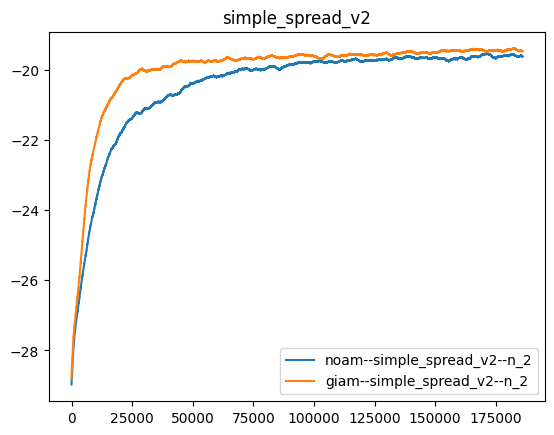

In [8]:
from matplotlib.pyplot import figure

vals = [] 
for env in envs: 
#     figure(figsize=(15, 10), dpi=80) 
    for e in exps: 
        if env in e: 
            print("exp:", e) 
            vals = [] 
            for l in logs: 
                if e in l: 
#                     print(l) 
                    x = np.load(l) 
#                     print(x.shape)
                    if (x.shape[0]>CUT): 
                        vals.append(x[INITIAL_CUT:CUT]) 
#             break 
            vals = np.array(vals)
#             print(vals.shape)
            val_means = smooth(np.mean(vals, axis=0), SMOOTH)[SMOOTH:-SMOOTH]
            val_stds = smooth(np.std(vals, axis=0), SMOOTH)[SMOOTH:-SMOOTH]
            plt.plot(val_means, label = e )
#     break 
    plt.title(env)
    plt.legend() 
    plt.show() 
    plt.close() 
